# Import modules

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding, Concatenate, Input, Dropout, Attention, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score

## Global variable

In [ ]:
MAX_VOCAB_SIZE = 10000
MAX_SEQ_LENGTH = 30
EMBEDDING_DIM = 256
LSTM_UNITS = 512
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
EPOCHS = 5

# Build model CNN_LSTM

In [ ]:
class VQAModel:
  def __init__(self, use_pretrained=True, use_attention=True):
    self.use_pretrained = use_pretrained
    self.use_attention = use_attention
    self.question_tokenizer = None
    self.answer_tokenizer = None
    self.model = None

  def load_data(self, json_path, images_dir):
    with open(json_path, 'r') as f:
      data = json.load(f)

    image_paths = []
    questions = []
    answers = []
    types = []
    captions = []

    for item in data:
      image_paths.append(os.path.join(images_dir, item['image_path']))
      questions.append(item['question'])
      answers.append(item['answer'])
      types.append(item['type'])
      captions.append(item['caption'])

    return {
        'image_paths': image_paths,
        'questions': questions,
        'answers': answers,
        'types': types,
        'captions': captions
    }

  def preprocess_data(self, train_questions, train_answers, val_questions=None, val_answers=None):
    """Text data preprocessing"""
    # Process questions
    self.question_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
    self.question_tokenizer.fit_on_texts(train_questions)

    train_q_seqs = self.question_tokenizer.texts_to_sequences(train_questions)
    train_q_seqs = pad_sequences(train_q_seqs, maxlen=MAX_SEQ_LENGTH)

    # Process answers
    self.answer_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
    self.answer_tokenizer.fit_on_texts(train_answers)

    train_a_seqs = self.answer_tokenizer.texts_to_sequences(train_answers)
    train_a_seqs = pad_sequences(train_a_seqs, maxlen=MAX_SEQ_LENGTH)

    if val_questions is not None and val_answers is not None:
      val_q_seqs = self.question_tokenizer.texts_to_sequences(val_questions)
      val_q_seqs = pad_sequences(val_q_seqs, maxlen=MAX_SEQ_LENGTH)

      val_a_seqs = self.answer_tokenizer.texts_to_sequences(val_answers)
      val_a_seqs = pad_sequences(val_a_seqs, maxlen=MAX_SEQ_LENGTH)

      return train_q_seqs, train_a_seqs, val_q_seqs, val_a_seqs

    return train_q_seqs, train_a_seqs

  def preprocess_images(self, image_paths):
    """Image data preprocessing"""
    images = []
    for path in image_paths:
      img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
      img = img_to_array(img)
      img = img / 255.0
      images.append(img)

    return np.array(images)

  def build_cnn_model(self):
    """Building a CNN model to learn image features"""
    if self.use_pretrained:
      base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
      for layer in base_model.layers:
        layer.trainable = False
    else:
      inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
      x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
      x = tf.keras.layers.MaxPooling2D((2, 2))(x)
      x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
      x = tf.keras.layers.MaxPooling2D((2, 2))(x)
      x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
      x = tf.keras.layers.MaxPooling2D((2, 2))(x)
      x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
      x = tf.keras.layers.MaxPooling2D((2, 2))(x)

      base_model = Model(inputs=inputs, outputs=x)

    return base_model

  def build_model(self):
    """Build a model combining CNN and LSTM to learn features and generate output"""
    # Image input and question input
    image_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    question_input = Input(shape=(MAX_SEQ_LENGTH,))

    # CNN model to process image
    cnn_model = self.build_cnn_model()

    # Images features
    image_features = cnn_model(image_input)
    image_features = Flatten()(image_features)
    image_features = Dense(EMBEDDING_DIM, activation='relu')(image_features)

    # Question embedding
    question_embedding = Embedding(
        input_dim=len(self.question_tokenizer.word_index) + 1,
        output_dim=EMBEDDING_DIM,
            input_length=MAX_SEQ_LENGTH
    )(question_input)

    # LSTM to process Questions
    if self.use_attention:
      # LSTM with Attention
      lstm_output = LSTM(LSTM_UNITS, return_sequences=True)(question_embedding)

      attention = tf.keras.layers.Attention()([lstm_output, lstm_output])
      question_features = Flatten()(attention)

    else:
      # LSTM without Attention
      lstm_output = LSTM(LSTM_UNITS)(question_embedding)
      question_features = lstm_output

    # Combine image and question features
    combined_features = Concatenate()([image_features, question_features])

    # Fully connected layers
    x = Dense(256, activation='relu')(combined_features)
    x = Dense(30, activation='softmax')(x)

    # Output predicts the answer
    answer_output = Dense(30, activation='softmax')(x)

    # Create the model
    model = Model(inputs=[image_input, question_input], outputs=answer_output)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    self.model = model
    return model

  def train(self, train_images, train_questions, train_answers, val_images=None, val_questions=None, val_answers=None):
    """Train the model"""
    callbacks = [
      EarlyStopping(patience=5, restore_best_weights=True),
            ModelCheckpoint('best_vqa_model.h5', save_best_only=True
        )
    ]
    if val_images is not None and val_questions is not None and val_answers is not None:
      history = self.model.fit(
          [train_images, train_questions],
          train_answers,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=([val_images, val_questions], val_answers),
          callbacks=callbacks
      )
    else:
      history = self.model.fit(
          [train_images, train_questions],
          train_answers,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.2,
          callbacks=callbacks
      )

    return history

  def predict(self, image_path, question):
    """Predict the answer to a question about a picture"""
    # Process images
    img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Process questions
    question_seq = self.question_tokenizer.texts_to_sequences([question])
    question_seq = pad_sequences(question_seq, maxlen=MAX_SEQ_LENGTH)

    # Predict
    prediction = self.model.predict([img, question_seq])

    # Convert pred to answer
    answer_idx = np.argmax(prediction[0])
    for word, idx in self.answer_tokenizer.word_index.items():
      if idx == answer_idx:
        return word

    return "Unknown"

  def evaluate(self, test_images, test_questions, test_answers):
    """Evaluate the model on test data"""
    predictions = self.model.predict([test_images, test_questions])
    predicted_answers = np.argmax(predictions, axis=1)
    true_answers = np.argmax(test_answers, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(true_answers, predicted_answers)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    return accuracy

# Run a test comparing different methods

In [ ]:
train_data = "/content/train_annotations.json"
val_data = "/content/val_annotations.json"
test_data = "/content/test_annotations.json"
images_dir = "/content/fruits/images"

In [ ]:
configurations = [
    {"use_pretrained": True, "use_attention": True, "name": "Pretrained CNN + LSTM with Attention"},
    {"use_pretrained": True, "use_attention": False, "name": "Pretrained CNN + LSTM without Attention"},
    {"use_pretrained": False, "use_attention": True, "name": "Custom CNN + LSTM with Attention"},
    {"use_pretrained": False, "use_attention": False, "name": "Custom CNN + LSTM without Attention"}
]

results = {}
histories = {}

for config in configurations:
  print(f"Running experiment: {config['name']}")

  vqa_model = VQAModel(
      use_pretrained=config["use_pretrained"],
      use_attention=config["use_attention"]
  )

  train = vqa_model.load_data(train_data, images_dir)
  val = vqa_model.load_data(val_data, images_dir)
  test = vqa_model.load_data(test_data, images_dir)

  # Text preprocessing
  train_q_seqs, train_a_seqs, val_q_seqs, val_a_seqs = vqa_model.preprocess_data(
      train["questions"], train["answers"], val["questions"], val["answers"]
  )

  test_q_seqs = vqa_model.question_tokenizer.texts_to_sequences(test["questions"])
  test_q_seqs = pad_sequences(test_q_seqs, maxlen=MAX_SEQ_LENGTH)
  test_a_seqs = vqa_model.answer_tokenizer.texts_to_sequences(test["answers"])
  test_a_seqs = pad_sequences(test_a_seqs, maxlen=MAX_SEQ_LENGTH)

  # Image preprocessing
  train_images = vqa_model.preprocess_images(train["image_paths"])
  val_images = vqa_model.preprocess_images(val["image_paths"])
  test_images = vqa_model.preprocess_images(test["image_paths"])

  vqa_model.build_model()
  print(f"\nModel: {config['name']}")
  vqa_model.model.summary()

  # Train
  history = vqa_model.train(
      train_images, train_q_seqs, train_a_seqs, val_images, val_q_seqs, val_a_seqs
  )

  histories[config["name"]] = history.history
  accuracy = vqa_model.evaluate(test_images, test_q_seqs, test_a_seqs)
  results[config["name"]] = accuracy

  vqa_model.model.save(f"vqa_model_{config['name'].replace(' ', '_').lower()}.keras")

Running experiment: Pretrained CNN + LSTM with Attention
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Model: Pretrained CNN + LSTM with Attention


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 30)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 30, 256)        │          7,424 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 30, 512)        │      1,574,912 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25088)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 30, 512)        │              0 │ lstm[0][0], lstm[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      6,422,784 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 15360)          │              0 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 15616)          │              0 │ dense[0][0],           │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │      3,997,952 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 30)             │          7,710 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 30)             │            930 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 26,726,400 (101.95 MB)

 Trainable params: 12,011,712 (45.82 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.0251 - loss: 5863.3794 

14/14 ━━━━━━━━━━━━━━━━━━━━ 405s 29s/step - accuracy: 0.0244 - loss: 5852.0146 - val_accuracy: 0.0110 - val_loss: 4633.0684
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 431s 28s/step - accuracy: 0.0045 - loss: 5656.0947 - val_accuracy: 0.0110 - val_loss: 4633.0977
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 418s 26s/step - accuracy: 0.0037 - loss: 5581.9287 - val_accuracy: 0.0110 - val_loss: 4633.2178
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 410s 29s/step - accuracy: 0.0017 - loss: 5813.7139 - val_accuracy: 0.0110 - val_loss: 4633.2388
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 434s 28s/step - accuracy: 0.0015 - loss: 5600.2783 - val_accuracy: 0.0110 - val_loss: 4633.5010
3/3 ━━━━━━━━━━━━━━━━━━━━ 64s 21s/step
Test Accuracy: 0.00%
Running experiment: Pretrained CNN + LSTM without Attention


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Model: Pretrained CNN + LSTM without Attention


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 30)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 25088)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 30, 256)        │          7,424 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │      6,422,784 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 512)            │      1,574,912 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 768)            │              0 │ dense_4[0][0],         │
│ (Concatenate)             │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 256)            │        196,864 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 30)             │          7,710 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 30)             │            930 │ dense_6[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 22,925,312 (87.45 MB)

 Trainable params: 8,210,624 (31.32 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.0280 - loss: 5371.9434 

14/14 ━━━━━━━━━━━━━━━━━━━━ 376s 27s/step - accuracy: 0.0280 - loss: 5392.5923 - val_accuracy: 0.0440 - val_loss: 4619.2065
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.0269 - loss: 5592.2588 

14/14 ━━━━━━━━━━━━━━━━━━━━ 391s 28s/step - accuracy: 0.0271 - loss: 5598.3564 - val_accuracy: 0.0440 - val_loss: 4619.0977
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 415s 26s/step - accuracy: 0.0319 - loss: 5636.6533 - val_accuracy: 0.0440 - val_loss: 4619.1245
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.0241 - loss: 5834.7075 

14/14 ━━━━━━━━━━━━━━━━━━━━ 384s 28s/step - accuracy: 0.0245 - loss: 5824.6338 - val_accuracy: 0.0440 - val_loss: 4619.0952
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 422s 26s/step - accuracy: 0.0367 - loss: 5799.3252 - val_accuracy: 0.0440 - val_loss: 4619.0957
3/3 ━━━━━━━━━━━━━━━━━━━━ 63s 21s/step
Test Accuracy: 3.26%
Running experiment: Custom CNN + LSTM with Attention


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Model: Custom CNN + LSTM with Attention


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 30)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 30, 256)        │          7,424 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_2 (Functional) │ (None, 12, 12, 256)    │        388,416 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 30, 512)        │      1,574,912 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 36864)          │              0 │ functional_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 30, 512)        │              0 │ lstm_2[0][0],          │
│                           │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 256)            │      9,437,440 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 15360)          │              0 │ attention_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 15616)          │              0 │ dense_8[0][0],         │
│ (Concatenate)             │                        │                │ flatten_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 256)            │      3,997,952 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 30)             │          7,710 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 30)             │            930 │ dense_10[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 15,414,784 (58.80 MB)

 Trainable params: 15,414,784 (58.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0406 - loss: 5699.9111

14/14 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - accuracy: 0.0412 - loss: 5699.7949 - val_accuracy: 0.0659 - val_loss: 4626.3472
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 83s 6s/step - accuracy: 0.0395 - loss: 5868.7876 - val_accuracy: 0.0659 - val_loss: 4626.3867
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.0466 - loss: 5808.7603 - val_accuracy: 0.0659 - val_loss: 4626.3965
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 75s 5s/step - accuracy: 0.0486 - loss: 5642.3457 - val_accuracy: 0.0659 - val_loss: 4626.3530
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.0543 - loss: 5758.9141 - val_accuracy: 0.0659 - val_loss: 4626.4126


2/3 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Test Accuracy: 0.00%
Running experiment: Custom CNN + LSTM without Attention


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Model: Custom CNN + LSTM without Attention


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_4 (Functional) │ (None, 12, 12, 256)    │        388,416 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_10            │ (None, 30)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 36864)          │              0 │ functional_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 30, 256)        │          7,424 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 256)            │      9,437,440 │ flatten_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 512)            │      1,574,912 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 768)            │              0 │ dense_12[0][0],        │
│ (Concatenate)             │                        │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 256)            │        196,864 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 30)             │          7,710 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 30)             │            930 │ dense_14[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,613,696 (44.30 MB)

 Trainable params: 11,613,696 (44.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0252 - loss: 5675.0562

14/14 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.0247 - loss: 5676.3613 - val_accuracy: 0.0110 - val_loss: 4599.0664
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0213 - loss: 5601.6201

14/14 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.0210 - loss: 5607.7764 - val_accuracy: 0.0110 - val_loss: 4598.9995
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 94s 6s/step - accuracy: 0.0149 - loss: 5727.2959 - val_accuracy: 0.0110 - val_loss: 4599.0391
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.0091 - loss: 5699.8120 - val_accuracy: 0.0110 - val_loss: 4599.1030
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 71s 5s/step - accuracy: 0.0122 - loss: 5907.7847 - val_accuracy: 0.0110 - val_loss: 4599.2026
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
Test Accuracy: 1.09%


# Plot the training graph

## Plot training history graph

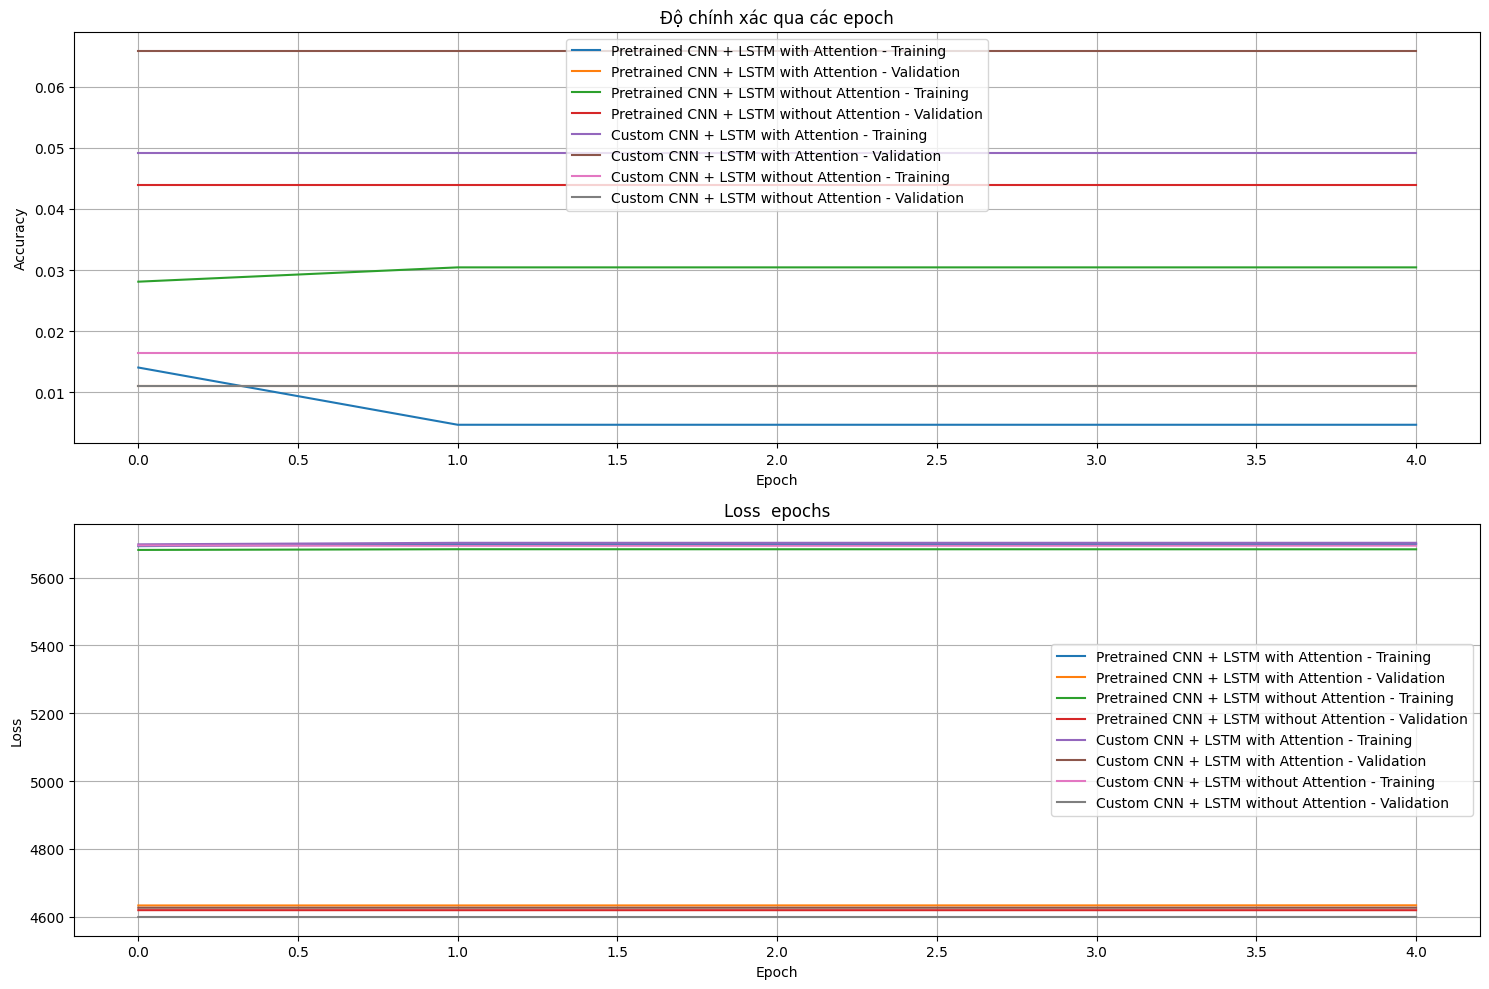

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
for name, history in histories.items():
  plt.plot(history['accuracy'], label=f'{name} - Training')
  plt.plot(history['val_accuracy'], label=f'{name} - Validation')

plt.title('Độ chính xác qua các epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for name, history in histories.items():
  plt.plot(history['loss'], label=f'{name} - Training')
  plt.plot(history['val_loss'], label=f'{name} - Validation')

plt.title('Loss  epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Graph the results

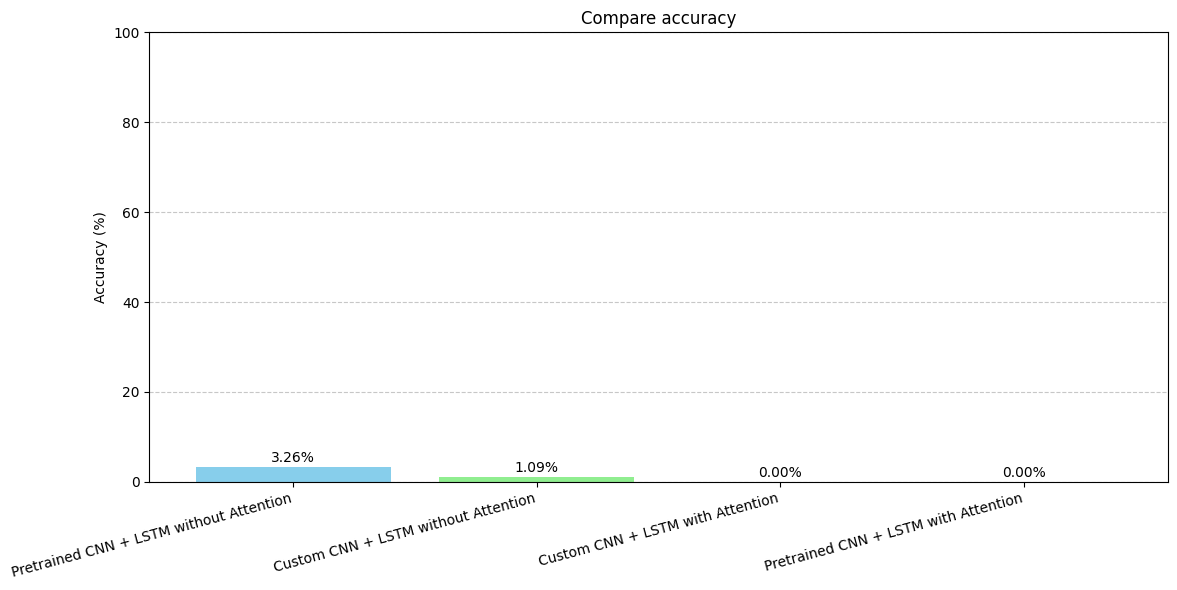

In [ ]:
plt.figure(figsize=(12, 6))
names = list(results.keys())
accuracies = [results[name] * 100 for name in names]

sorted_indices = np.argsort(accuracies)[::-1]
names = [names[i] for i in sorted_indices]
accuracies = [accuracies[i] for i in sorted_indices]

bars = plt.bar(names, accuracies, color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon'])

for bar in bars:
  height = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{height:.2f}%', ha='center', va='bottom')

plt.title('Compare accuracy')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Testing result

In [ ]:
best_model_name = max(results, key=results.get).replace(' ', '_').lower()
best_model_path = f"vqa_model_{best_model_name}.keras"

model = VQAModel(
    use_pretrained=True,
    use_attention=True
)

train = model.load_data(train_data, images_dir)
model.preprocess_data(train["questions"], train["answers"])

loaded_model = tf.keras.models.load_model(best_model_path)
model.model = loaded_model

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def predict_and_show(image_path, question):
  plt.figure(figsize=(8, 8))
  img = plt.imread(image_path)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f"Question: {question}")

  answer = model.predict(image_path, question)
  plt.figtext(0.5, 0.01, f"Answer: {answer}", ha="center", fontsize=12, bbox={"facecolor":"yellow", "alpha":0.5, "pad":5})
  plt.tight_layout()
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


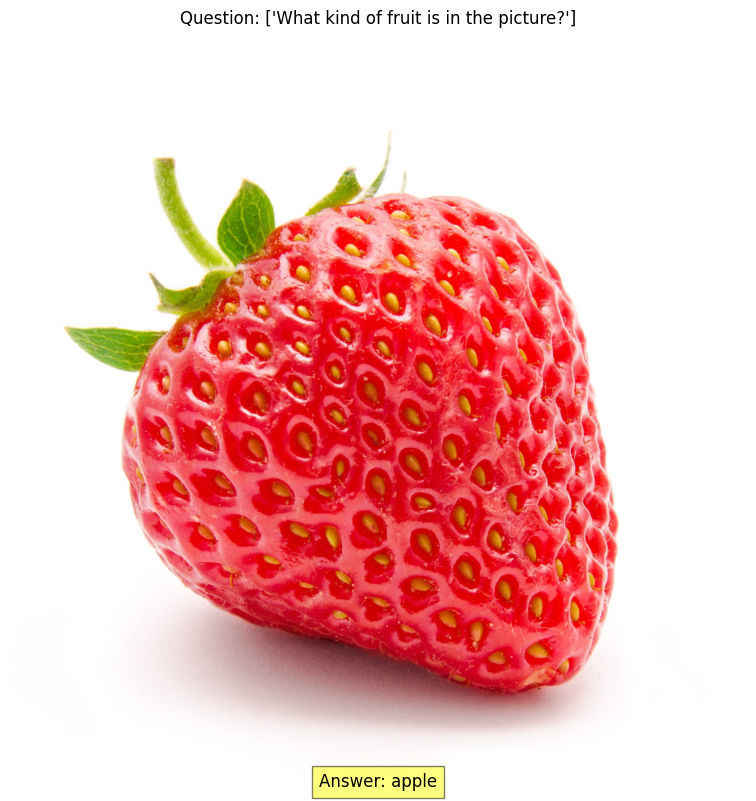

In [ ]:
test_image = "/content/fruits/images/Img (10).jpeg"
questions = [
    "What kind of fruit is in the picture?"
]
predict_and_show(test_image, questions)